# SWOP script 5b - Linear Mixed Effects Analysis with SCT data
## 900-1000 ms time window

This script imports a CSV file generated by the script *SWOP 4 - Measure ERPS* and performs linear mixed effects modelling.

Following general best practices, we are using **individual trial** data. Note that outliers (defined as data points at the level of subjets/trials/channels with abs(*z*) > 2.5) have been removed in script 4. 

A few technical notes:
- while LME is most commonly run using the *lmer()* function in the *lme4* package, we instead use the *bam()* function in the *mgcv* package. While mgcv/bam is written for generalized additive modelling, it allows for LME by using the *bs='re'* flag for smooths (where  're' stands for 'random effects'). The *bam()* function is parallelized, as well as being well-optimized, making it much faster to run, and without convergence errors that sometimes plague *lmer()* models
- best practices  in LME modelling tend to encourage full random effects models, and also by-item random effects and even random slopes for items within subjects. However, these models quickly become computationally very expensive, both in terms of time and RAM required. They are computed  here, but it is impossible to generate the tables of results and effet sizes with *emmeans()*, nor plot the contrasts of interest. My past experience, as well as experience with this dataset, is that these more elaborate random effects models do generate much smaller AIC values, and higher explained variance of the models. However, they do not in any appreciable way impact the general pattern of results (in terms of what's significant in the ANOVA tables, nor the effect sizes of our contrasts of interest). For these reasons, the models we ultimately present are not the "best" in the sense of AIC values or explained variance, but they tell efefctively the same story. For reference, however, the more complex models are computed and summarized here for reference. 

---
Copyright 2016-21  [Aaron J Newman](https://github.com/aaronjnewman), [NeuroCognitive Imaging Lab](http://ncil.science), [Dalhousie University](https://dal.ca)

Released under the [BSD 3-clause license](https://opensource.org/licenses/BSD-3-Clause)

---

## Load necessary libraries

In [32]:
date()

[1] "Tue Sep 21 19:14:17 2021"

In [33]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(mgcv)
library(parallel)
# library(viridis)
library(emmeans)
library(sjPlot)

## Set parameters for this analysis

In [34]:
component = '900-1000'
expt = 'SWOP'
data_path = '../group_data/'
out_path = '../results/'

data_file = paste(data_path, 'SWOP_ERP_measurements.csv', sep="")
behav_file = paste(data_path, 'SWOP_demographic_behavioural_data.csv', sep="")

# num parallel processes for bam(). Should be less than the number of threads supported by your CPU
num_cores = 14

options("scipen"=100, "digits"=5)  # force decimal instead of scientific notation

## Load Data

In [35]:
dat <- read.csv(data_file,
               colClasses=c('factor', 'numeric', 'factor', 
                            'factor', 'factor', 'factor', 
                            'factor',  'factor', 'factor', 
                            'numeric', 'factor', 'factor',
                            'factor', 'factor', 'factor', 
                            'factor', 'numeric', 'factor',
                            'numeric'
                           )
               )

dat$ROI <- factor(dat$ROI, levels=c('L_Ant', 'M_Ant', 'R_Ant',
                                       'L_Cent', 'M_Cent', 'R_Cent',
                                       'L_Post', 'M_Post', 'R_Post'
                                      ))

# specify ordering of condtiions, for plots and contrats
dat$Adverb <- factor(dat$Adverb, levels=c('kanske', 'hemma', 'idag'))
# Force contrasts as V3-V2
dat$SentPos <- factor(dat$SentPos, levels=c('V3', 'V2'))

### Select only data for ERP component of interest

In [36]:
dat <- subset(dat, Component==component | Component=='baseline')
dat <- droplevels(dat)

### Remove missing data 

In [37]:
dat <- dat[complete.cases(dat), ]

## Summary/Descriptives

In [38]:
summary(dat)

    Subject        Trial.Time          Condition          ROI       
 s_04nm : 6275   Min.   :   1157   V2/hemma :20236   L_Post :18441  
 s_21ma : 6152   1st Qu.: 497829   V2/idag  :20113   L_Cent :18440  
 s_19am : 6128   Median :1070614   V2/kanske:20266   R_Cent :18307  
 s_27lm : 6126   Mean   :1096198   V3/hemma :20369   R_Ant  :18148  
 s_25ks : 6124   3rd Qu.:1653481   V3/idag  :20183   R_Post :18122  
 s_12wg : 6117   Max.   :2977152   V3/kanske:20438   L_Ant  :18052  
 (Other):84683                                       (Other):12095  
    Channel         Sentence      postphrase  pronoun_noun questiondisplay.ACC
 TP7    : 4773   180    :   534   0.0:20063   N:60827      0: 19629           
 TP8    : 4770   219    :   532   1.0:22250   P:60778      1:101976           
 P7     : 4767   231    :   532   2.0:16650                                   
 T8     : 4763   287    :   532   3.0:24226                                   
 T7     : 4742   290    :   531   4.0:21829          

In [39]:
str(dat)

'data.frame':	121605 obs. of  19 variables:
 $ Subject            : Factor w/ 20 levels "s_04nm","s_07ba",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Trial.Time         : num  34102 34102 34102 34102 34102 ...
 $ Condition          : Factor w/ 6 levels "V2/hemma","V2/idag",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ ROI                : Factor w/ 9 levels "L_Ant","M_Ant",..: 1 1 1 1 4 4 4 4 7 7 ...
 $ Channel            : Factor w/ 27 levels "C3","C4","CP3",..: 6 8 10 12 1 3 24 26 15 17 ...
 $ Sentence           : Factor w/ 240 levels "10","101","102",..: 215 215 215 215 215 215 215 215 215 215 ...
 $ postphrase         : Factor w/ 6 levels "0.0","1.0","2.0",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ pronoun_noun       : Factor w/ 2 levels "N","P": 1 1 1 1 1 1 1 1 1 1 ...
 $ questiondisplay.ACC: Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ questiondisplay.RT : num  213 213 213 213 213 213 213 213 213 213 ...
 $ sentence_no        : Factor w/ 40 levels "1.0","10.0","11.0",..: 15 15 15 15 15 15 15 15 15 15 ...
 $ s

## Read behavioural data


In [40]:
behav <- read.csv(behav_file)
behav$Subject <- as.factor(behav$Subject)

In [41]:
summary(behav)

    Subject        Age           Swedex        Eng.profic         SES      
 s_04nm : 1   Min.   :19.0   Min.   : 9.00   Min.   :0.620   Min.   :14.0  
 s_07ba : 1   1st Qu.:20.2   1st Qu.: 9.75   1st Qu.:0.835   1st Qu.:37.5  
 s_09lo : 1   Median :22.2   Median : 9.75   Median :0.890   Median :52.2  
 s_12wg : 1   Mean   :23.8   Mean   : 9.79   Mean   :0.862   Mean   :48.4  
 s_13ff : 1   3rd Qu.:26.9   3rd Qu.:10.00   3rd Qu.:0.920   3rd Qu.:60.6  
 s_14mc : 1   Max.   :34.3   Max.   :10.00   Max.   :0.960   Max.   :66.0  
 (Other):14                                                                
     Mat.Ed     PropnSwedisUse  PropnEngUse    AoA.English       numL2    
 Min.   :2.00   Min.   :50.0   Min.   : 1.0   Min.   : 6.0   Min.   :1.0  
 1st Qu.:3.75   1st Qu.:63.8   1st Qu.:10.0   1st Qu.: 8.0   1st Qu.:2.0  
 Median :5.50   Median :77.5   Median :19.2   Median : 9.5   Median :2.0  
 Mean   :4.85   Mean   :75.7   Mean   :20.7   Mean   : 9.4   Mean   :2.5  
 3rd Qu.:6.00   3

In [42]:
dat <- merge(dat, behav, by=c('Subject'))
summary(dat)

    Subject        Trial.Time          Condition          ROI       
 s_04nm : 6275   Min.   :   1157   V2/hemma :20236   L_Post :18441  
 s_21ma : 6152   1st Qu.: 497829   V2/idag  :20113   L_Cent :18440  
 s_19am : 6128   Median :1070614   V2/kanske:20266   R_Cent :18307  
 s_27lm : 6126   Mean   :1096198   V3/hemma :20369   R_Ant  :18148  
 s_25ks : 6124   3rd Qu.:1653481   V3/idag  :20183   R_Post :18122  
 s_12wg : 6117   Max.   :2977152   V3/kanske:20438   L_Ant  :18052  
 (Other):84683                                       (Other):12095  
    Channel         Sentence      postphrase  pronoun_noun questiondisplay.ACC
 TP7    : 4773   180    :   534   0.0:20063   N:60827      0: 19629           
 TP8    : 4770   219    :   532   1.0:22250   P:60778      1:101976           
 P7     : 4767   231    :   532   2.0:16650                                   
 T8     : 4763   287    :   532   3.0:24226                                   
 T7     : 4742   290    :   531   4.0:21829          

## Get counts of trials in each cell of design
We select data from Cz just to avoid repeated measures for all the electrodes

In [43]:
crosstab <- xtabs(~ SentPos + Adverb, data=subset(dat, Component==component & Channel=='Cz'))
ftable(crosstab) # print table 
summary(crosstab) #

        Adverb kanske hemma idag
SentPos                         
V3                658   664  669
V2                650   654  638

Call: xtabs(formula = ~SentPos + Adverb, data = subset(dat, Component == 
    component & Channel == "Cz"))
Number of cases in table: 3933 
Number of factors: 2 
Test for independence of all factors:
	Chisq = 0.25, df = 2, p-value = 0.88

### Visualize distributions

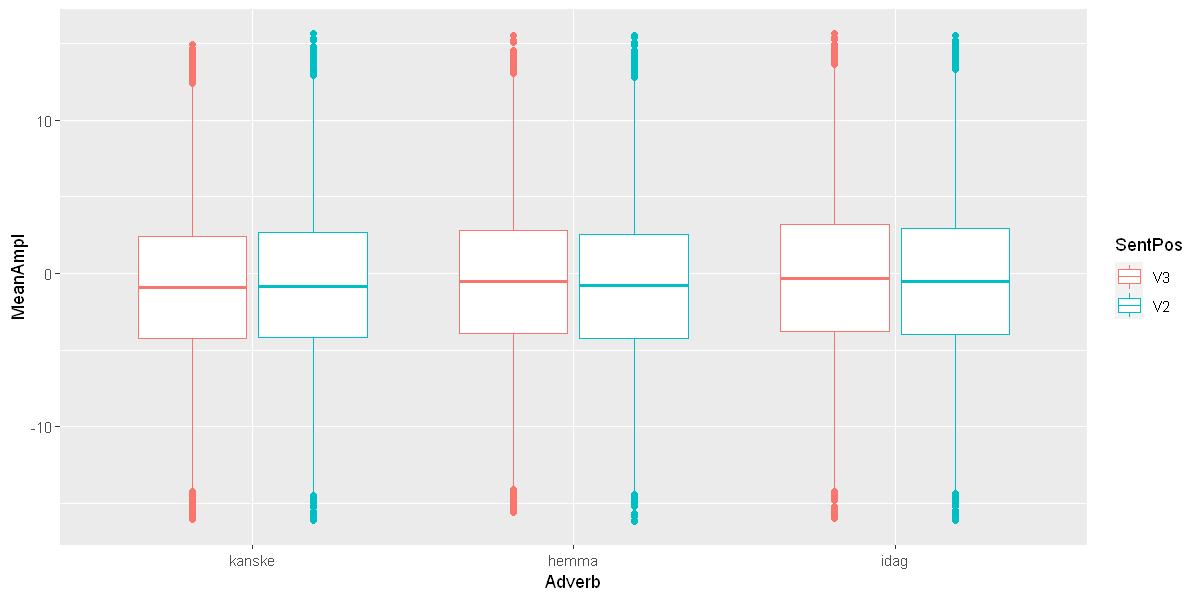

In [44]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(dat, aes(y=MeanAmpl, x=Adverb, col=SentPos)) + 
    geom_boxplot() 

## LME modelling

Note: we use the `bam()` function but fit linear models.

### Fit a simple-but-full model without baseline

In [45]:
cl <- makeCluster(num_cores)  

m0 <- bam(MeanAmpl ~ (Adverb * SentPos * ROI)
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)


Method: fREML   Optimizer: perf newton
full convergence after 8 iterations.
Gradient range [-0.0000032627,-0.0000000000065725]
(score 371351 & scale 26.267).
Hessian positive definite, eigenvalue range [9.2618,60776].
Model rank =  74 / 74 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

             k'  edf k-index p-value
s(Subject) 20.0 18.8      NA      NA


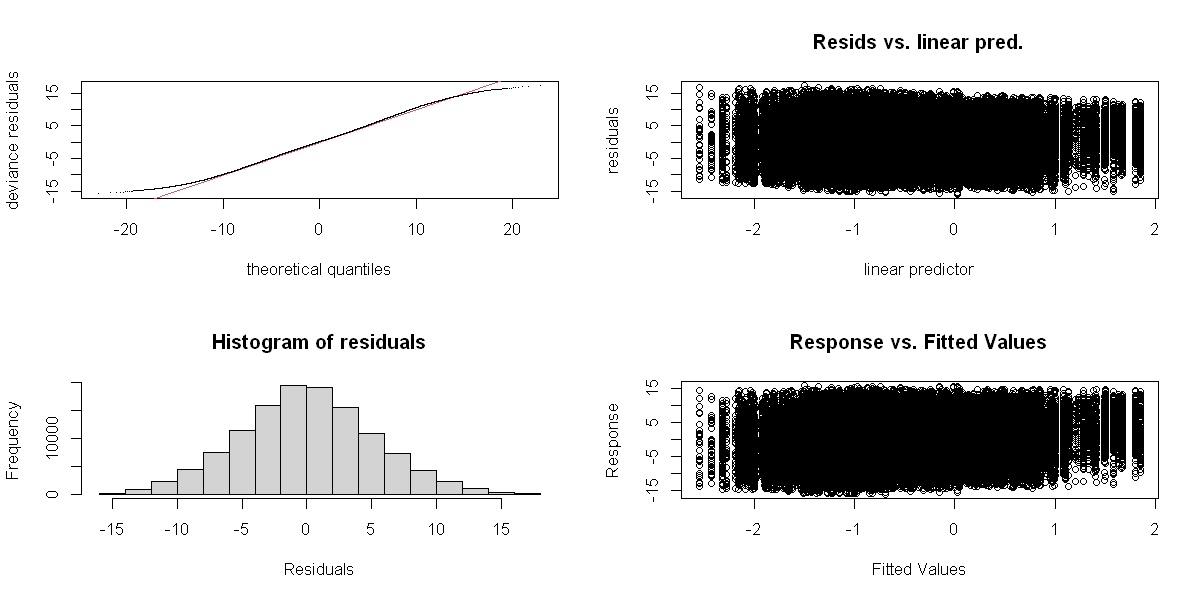

In [46]:
gam.check(m0)

In [47]:
anova(m0)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb * SentPos * ROI) + s(Subject, bs = "re")

Parametric Terms:
                   df    F              p-value
Adverb              2 2.92                0.054
SentPos             1 0.14                0.707
ROI                 8 8.19     0.00000000003841
Adverb:SentPos      2 1.68                0.186
Adverb:ROI         16 8.39 < 0.0000000000000002
SentPos:ROI         8 0.87                0.545
Adverb:SentPos:ROI 16 5.92     0.00000000000033

Approximate significance of smooth terms:
            edf Ref.df    F             p-value
s(Subject) 18.8   19.0 78.7 <0.0000000000000002

### Add random intercepts for items (sentences) as well as subjects

In [48]:
cl <- makeCluster(num_cores)  

mf_4w_rei <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

In [49]:
cl <- makeCluster(num_cores)  

mf_4w_rei_sct <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + (Adverb + SentPos + ROI + SCT.overall.V2pct)^4
          + s(Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

## Compare models

In [50]:
AICtab <- as.data.frame(AIC(mf_4w_rei, mf_4w_rei_sct
                           )) 
AICtab$deltaAIC <-AICtab$AIC - min(AICtab$AIC)
AICtab[order(AICtab$AIC),]

,df,AIC,deltaAIC
,<dbl>,<dbl>,<dbl>
mf_4w_rei_sct,404.41,737162,0.0000
mf_4w_rei,351.50,737167,5.6822


---
## Explore best model

### Best Model

**`mf_4w_recsis`** has smallest AIC

However, the random effects structure is so complex that we can't generate plots of this model below (requires more RAM than we have; takes > 24 h to fit and then maybe crashes). For those we use the model **`mf_4w_reci`**, which is the same but with only random intercepts by sentence, not sentence-by-subject RE

The plotted effect sizes and confidence intervals do not change in any visually-detectable way between these models with different random effects structures anyway.

In [51]:
anova(mf_4w_rei)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Subject, 
    bs = "re") + s(Sentence, bs = "re")

Parametric Terms:
                            df     F              p-value
Adverb                       2  1.30                0.272
SentPos                      1  0.13                0.714
ROI                          8 10.35    0.000000000000013
baseline                     1 42.35    0.000000000076768
Adverb:SentPos               2  1.35                0.260
Adverb:ROI                  16  8.70 < 0.0000000000000002
Adverb:baseline              2  0.62                0.536
SentPos:ROI                  8  1.04                0.403
SentPos:baseline             1  5.58                0.018
ROI:baseline                 8  2.13                0.030
Adverb:SentPos:ROI          16  6.76    0.000000000000001
Adverb:SentPos:baseline      2  1.71                0.182
Adverb:ROI:baseline         16  0.94                0.524
SentPos:ROI:

In [52]:
anova(mf_4w_rei_sct)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + (Adverb + 
    SentPos + ROI + SCT.overall.V2pct)^4 + s(Subject, bs = "re") + 
    s(Sentence, bs = "re")

Parametric Terms:
                                     df     F       p-value
Adverb                                2  3.21         0.040
SentPos                               1  0.76         0.382
ROI                                   8  1.07         0.384
baseline                              1 43.20 0.00000000005
SCT.overall.V2pct                     1  1.80         0.179
Adverb:SentPos                        2  3.80         0.022
Adverb:ROI                           16  1.17         0.281
Adverb:baseline                       2  0.67         0.513
SentPos:ROI                           8  1.07         0.380
SentPos:baseline                      1  5.39         0.020
ROI:baseline                          8  2.20         0.024
Adverb:SCT.overall.V2pct              2  3.33     

In [53]:
mod <- mf_4w_rei_sct

### Write ANOVA table to text file

In [54]:
capture.output(anova(mod), file=paste(out_path, 'anova_table_', component, '_SCT.txt', sep=""))

In [55]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + (Adverb + 
    SentPos + ROI + SCT.overall.V2pct)^4 + s(Subject, bs = "re") + 
    s(Sentence, bs = "re")

Parametric coefficients:
                                                    Estimate Std. Error t value
(Intercept)                                        -6.312983   4.114233   -1.53
Adverbhemma                                         7.268363   3.224310    2.25
Adverbidag                                          6.891990   3.237933    2.13
SentPosV2                                           2.818239   3.226187    0.87
ROIM_Ant                                            0.838113   5.321910    0.16
ROIR_Ant                                           -4.062779   3.220131   -1.26
ROIL_Cent                                           2.499147   3.211246    0.78
ROIM_Cent                                          -1.394484   5.382996   -0.26
ROIR_Cent                                  

## View results

In [56]:
contr <- emmeans(mod,  pairwise ~ SentPos | SCT.overall.V2pct * ROI)

contr_tab = contr$contrasts %>% as.data.frame()
ncomp = nrow(contr_tab)
contr_tab$'p (raw)'   = round(contr_tab$'p.value', 4)
contr_tab$'p (FDR BH)' = round(p.adjust(contr_tab$'p.value', method = 'BH', n = ncomp), 4)
contr_tab <- subset(contr_tab, select=-c(p.value))
contr_tab

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



,contrast,SCT.overall.V2pct,ROI,estimate,SE,df,t.ratio,p (raw),p (FDR BH)
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,V3 - V2,0.95406,L_Ant,-0.219848,0.074870,121202,-2.93639,0.0033,0.0075
2,V3 - V2,0.95406,M_Ant,-0.196674,0.158070,121202,-1.24422,0.2134,0.2744
3,V3 - V2,0.95406,R_Ant,-0.031800,0.074818,121202,-0.42502,0.6708,0.6708
4,V3 - V2,0.95406,L_Cent,-0.036431,0.074676,121202,-0.48786,0.6257,0.6708
5,V3 - V2,0.95406,M_Cent,0.428548,0.162115,121202,2.64347,0.0082,0.0123
6,V3 - V2,0.95406,R_Cent,0.293063,0.074746,121202,3.92079,0.0001,0.0004
7,V3 - V2,0.95406,L_Post,0.206360,0.074631,121202,2.76506,0.0057,0.0102
8,V3 - V2,0.95406,M_Post,0.540578,0.158903,121202,3.40194,0.0007,0.0020
9,V3 - V2,0.95406,R_Post,0.624746,0.075068,121202,8.32234,0.0000,0.0000


In [69]:
posthocs <- emtrends(mod, pairwise ~ SentPos * Adverb, var = "SCT.overall.V2pct")

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



In [70]:
posthocs$emtrends

 SentPos Adverb SCT.overall.V2pct.trend   SE     df lower.CL upper.CL
 V3      kanske                   7.222 3.77 121202   -0.173    14.62
 V2      kanske                   2.173 3.77 121202   -5.220     9.57
 V3      hemma                   -0.507 3.77 121202   -7.905     6.89
 V2      hemma                    4.857 3.78 121202   -2.545    12.26
 V3      idag                    -2.590 3.77 121202   -9.983     4.80
 V2      idag                     3.358 3.77 121202   -4.038    10.76

Results are averaged over the levels of: ROI, Subject, Sentence 
Confidence level used: 0.95 

In [71]:
capture.output(posthocs$emtrends, file=paste(out_path, 'emtrends_table_', component, '_SCTxSentPosxAdverb.txt', sep=""))

In [72]:
posthocs$contrasts

 contrast              estimate   SE     df t.ratio p.value
 V3 kanske - V2 kanske     5.05 1.67 121202   3.019  0.0305
 V3 kanske - V3 hemma      7.73 1.67 121202   4.639  <.0001
 V3 kanske - V2 hemma      2.36 1.67 121202   1.416  0.7176
 V3 kanske - V3 idag       9.81 1.66 121202   5.907  <.0001
 V3 kanske - V2 idag       3.86 1.66 121202   2.320  0.1857
 V2 kanske - V3 hemma      2.68 1.66 121202   1.611  0.5913
 V2 kanske - V2 hemma     -2.68 1.67 121202  -1.609  0.5924
 V2 kanske - V3 idag       4.76 1.66 121202   2.872  0.0470
 V2 kanske - V2 idag      -1.19 1.66 121202  -0.713  0.9804
 V3 hemma - V2 hemma      -5.36 1.69 121202  -3.181  0.0184
 V3 hemma - V3 idag        2.08 1.66 121202   1.251  0.8114
 V3 hemma - V2 idag       -3.87 1.67 121202  -2.317  0.1871
 V2 hemma - V3 idag        7.45 1.67 121202   4.463  0.0001
 V2 hemma - V2 idag        1.50 1.67 121202   0.896  0.9476
 V3 idag - V2 idag        -5.95 1.68 121202  -3.550  0.0052

Results are averaged over the levels of

In [74]:
capture.output(posthocs$contrasts, file=paste(out_path, 'contrast_table_', component, '_SCTxSentPoxAdverbs.txt', sep=""))

## Get effect sizes on differences 
Cohen's *d*

### Plot effect sizes for all V3-V2 contrasts

Also save a PDF version of the plot

Since 'object' is a list, we are using the contrasts already present.



png 
  2

Since 'object' is a list, we are using the contrasts already present.



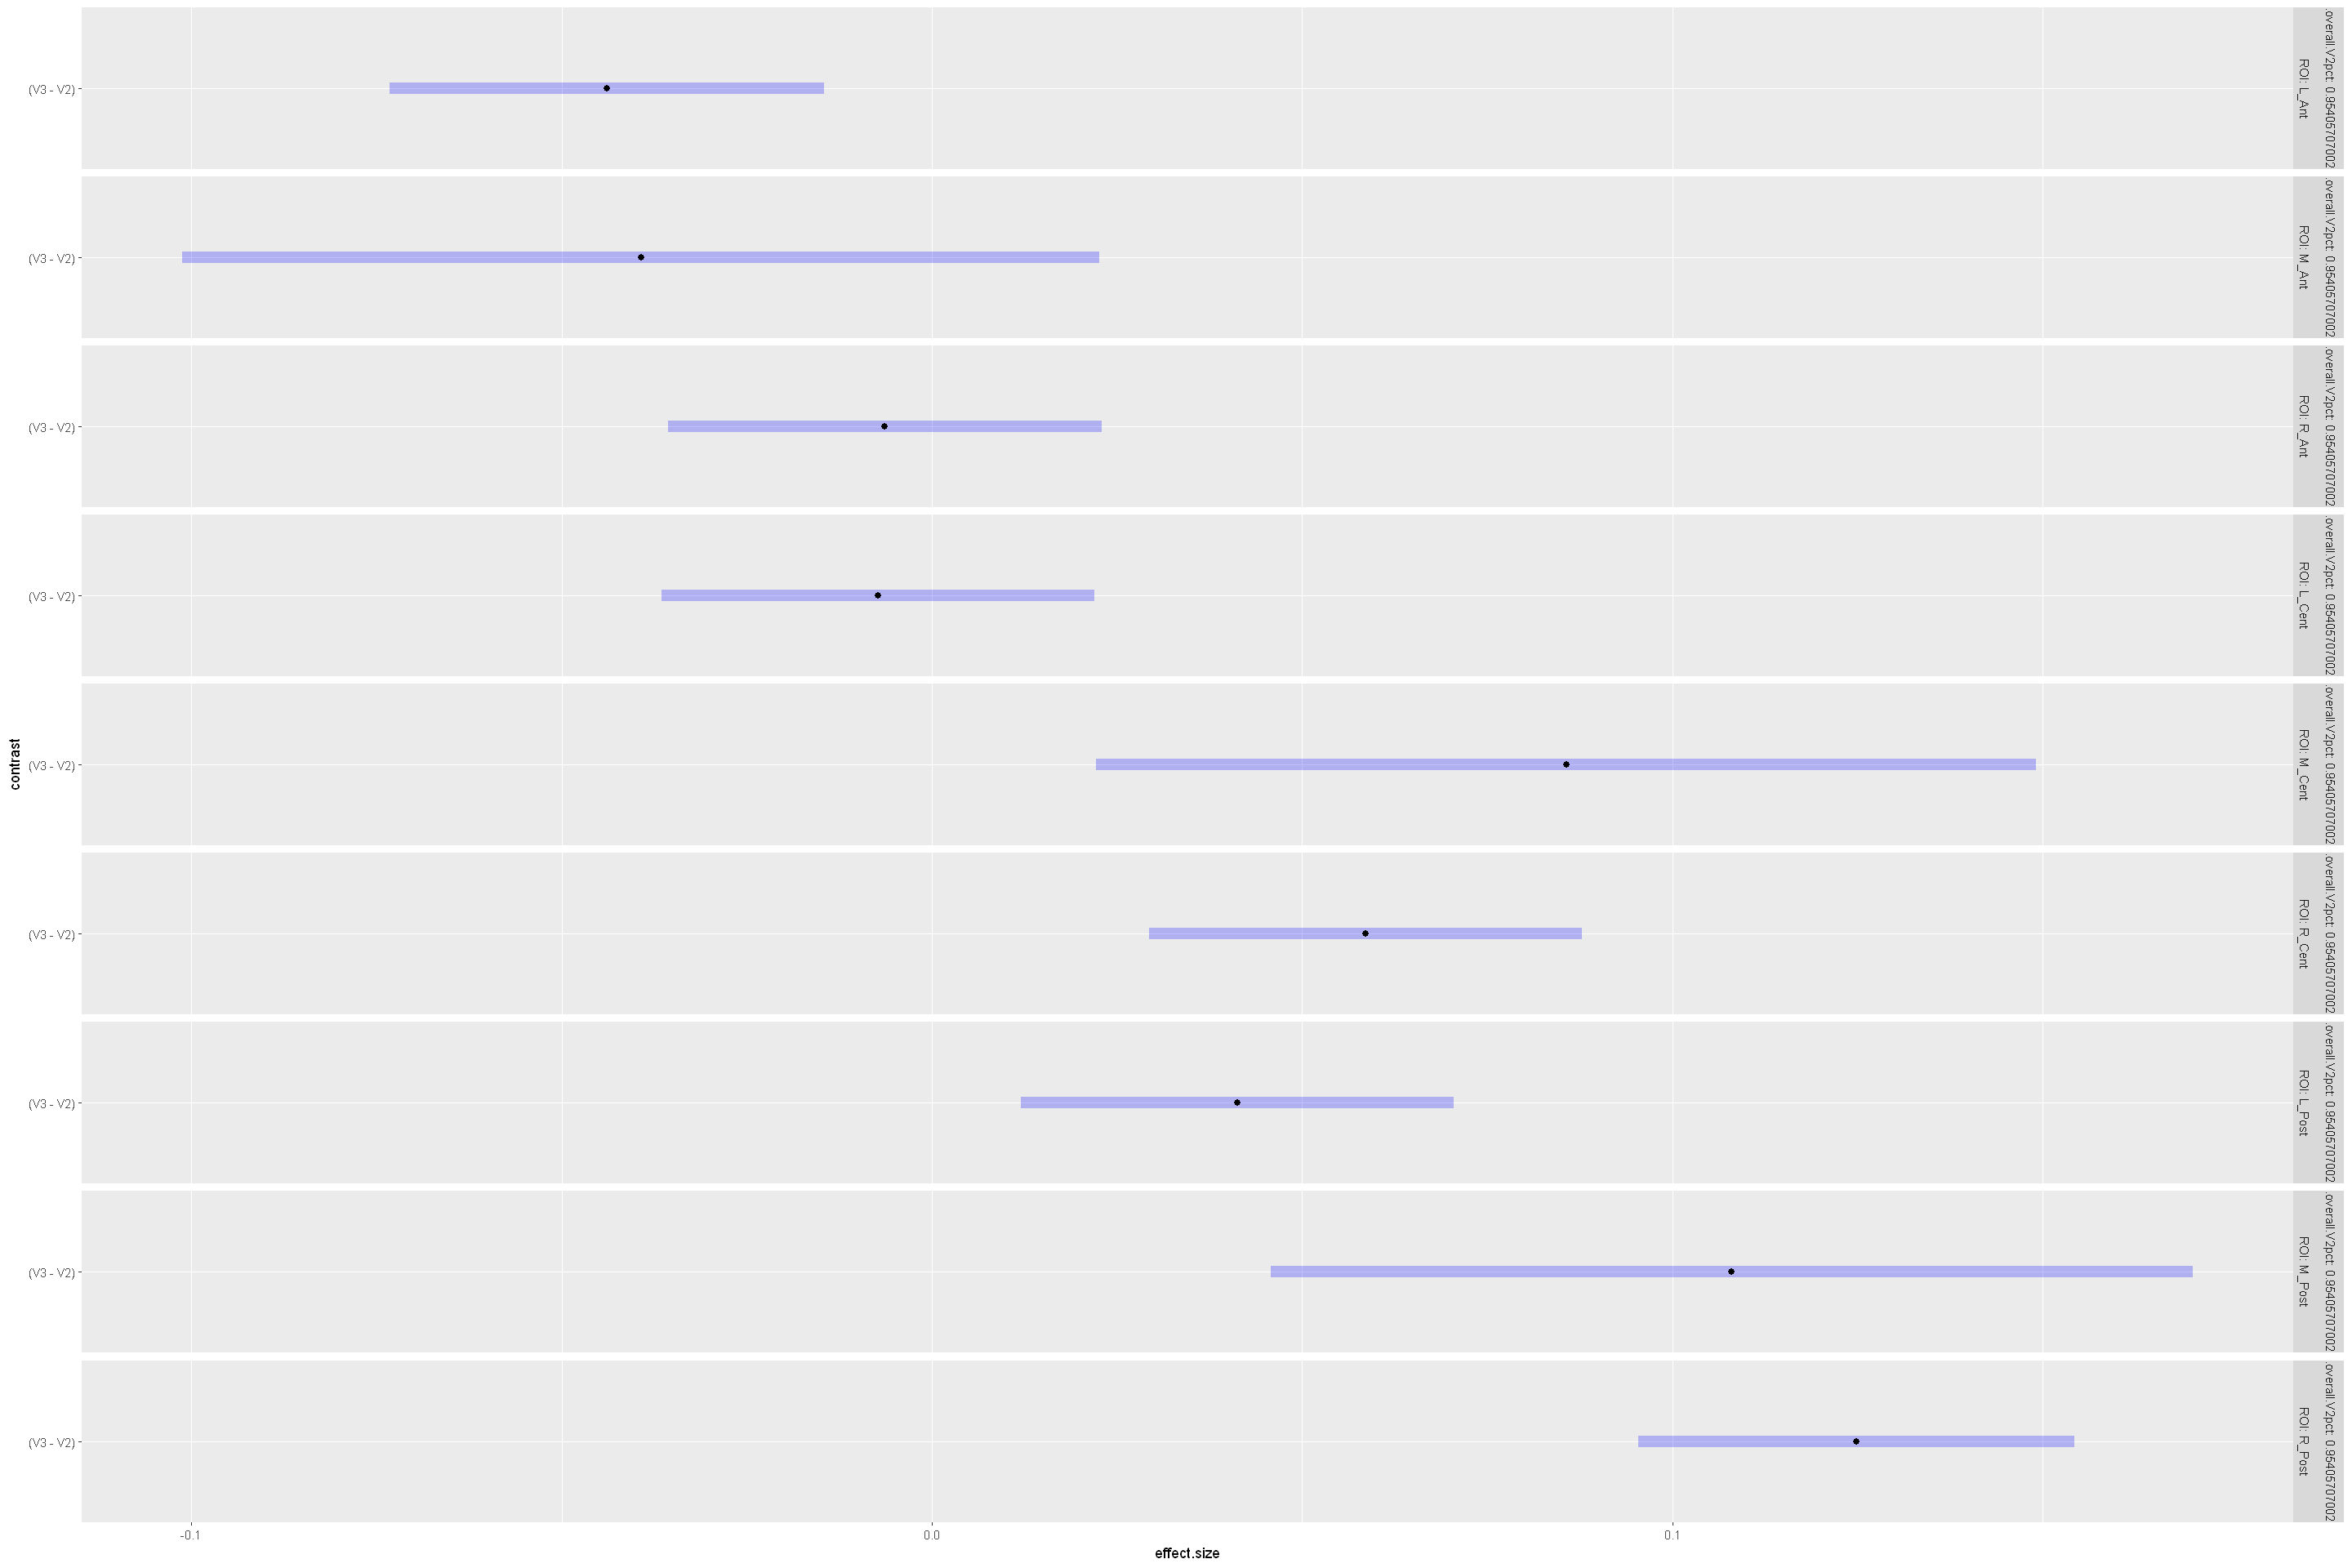

In [57]:
pdf(paste(out_path, 'figures/R plots/', 'lme_effect_plot_', component, '_SCT.pdf', sep="")) 
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))
dev.off() 
options(repr.plot.width=24, repr.plot.height=16)
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))

In [58]:
# eff_tab <- eff_size(contr, sigma = sigma(mod), edf = 125000) %>% as.data.frame()
# full_tab <- contr_tab %>% full_join(eff_tab, by=c("ROI", 'Adverb'), suffix = c(".ctr", ".eff"))
# full_tab

### Write above table to file

In [59]:
# write.csv(full_tab, file=paste(out_path, 'contrast_table_', component, '_SCT.csv' ,sep=''))

## Plot Model

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



png 
  2

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



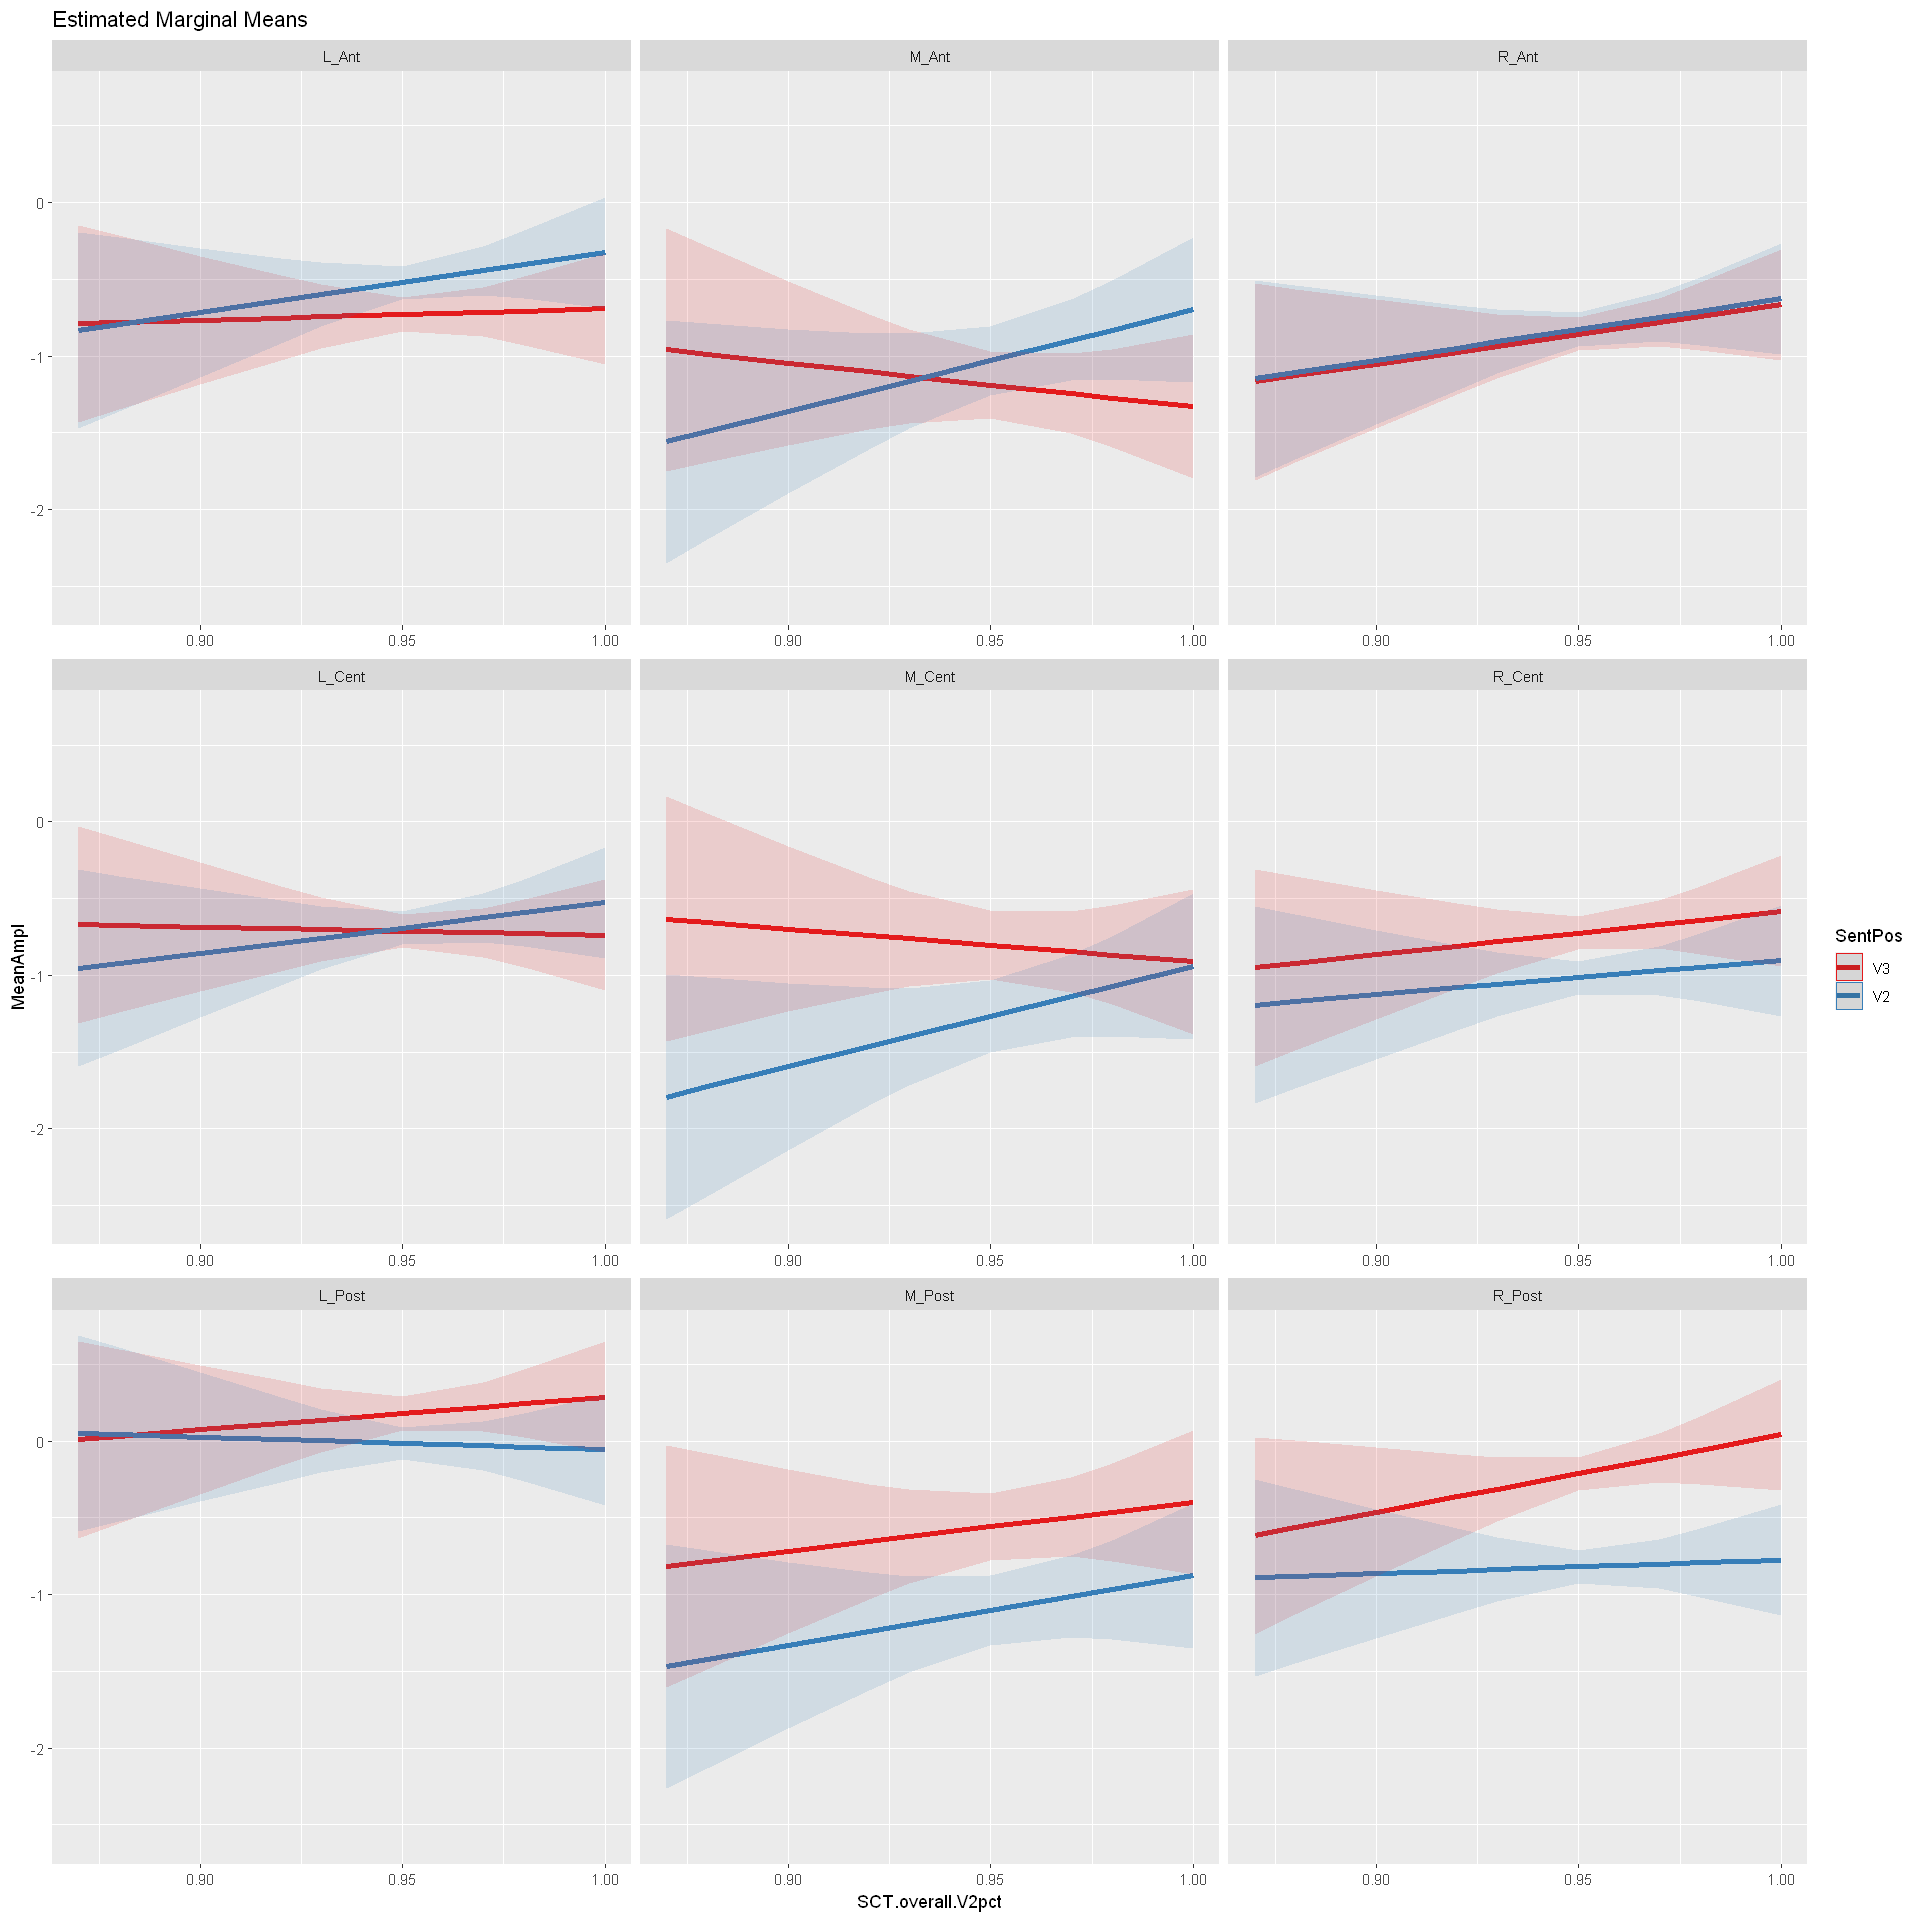

In [60]:
# save PDF
pdf(paste(out_path, 'figures/R plots/', 'lme_model_plot_', component, '_SCTxSentPosxROI.pdf', sep="")) 
plot_model(mod, 
           type='emm',
           terms=c('SCT.overall.V2pct', 'SentPos', 'ROI'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )
dev.off() 

# plot in this notebook
options(repr.plot.width=16, repr.plot.height=16)
plot_model(mod, 
           type='emm',
           terms=c('SCT.overall.V2pct', 'SentPos', 'ROI'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



png 
  2

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



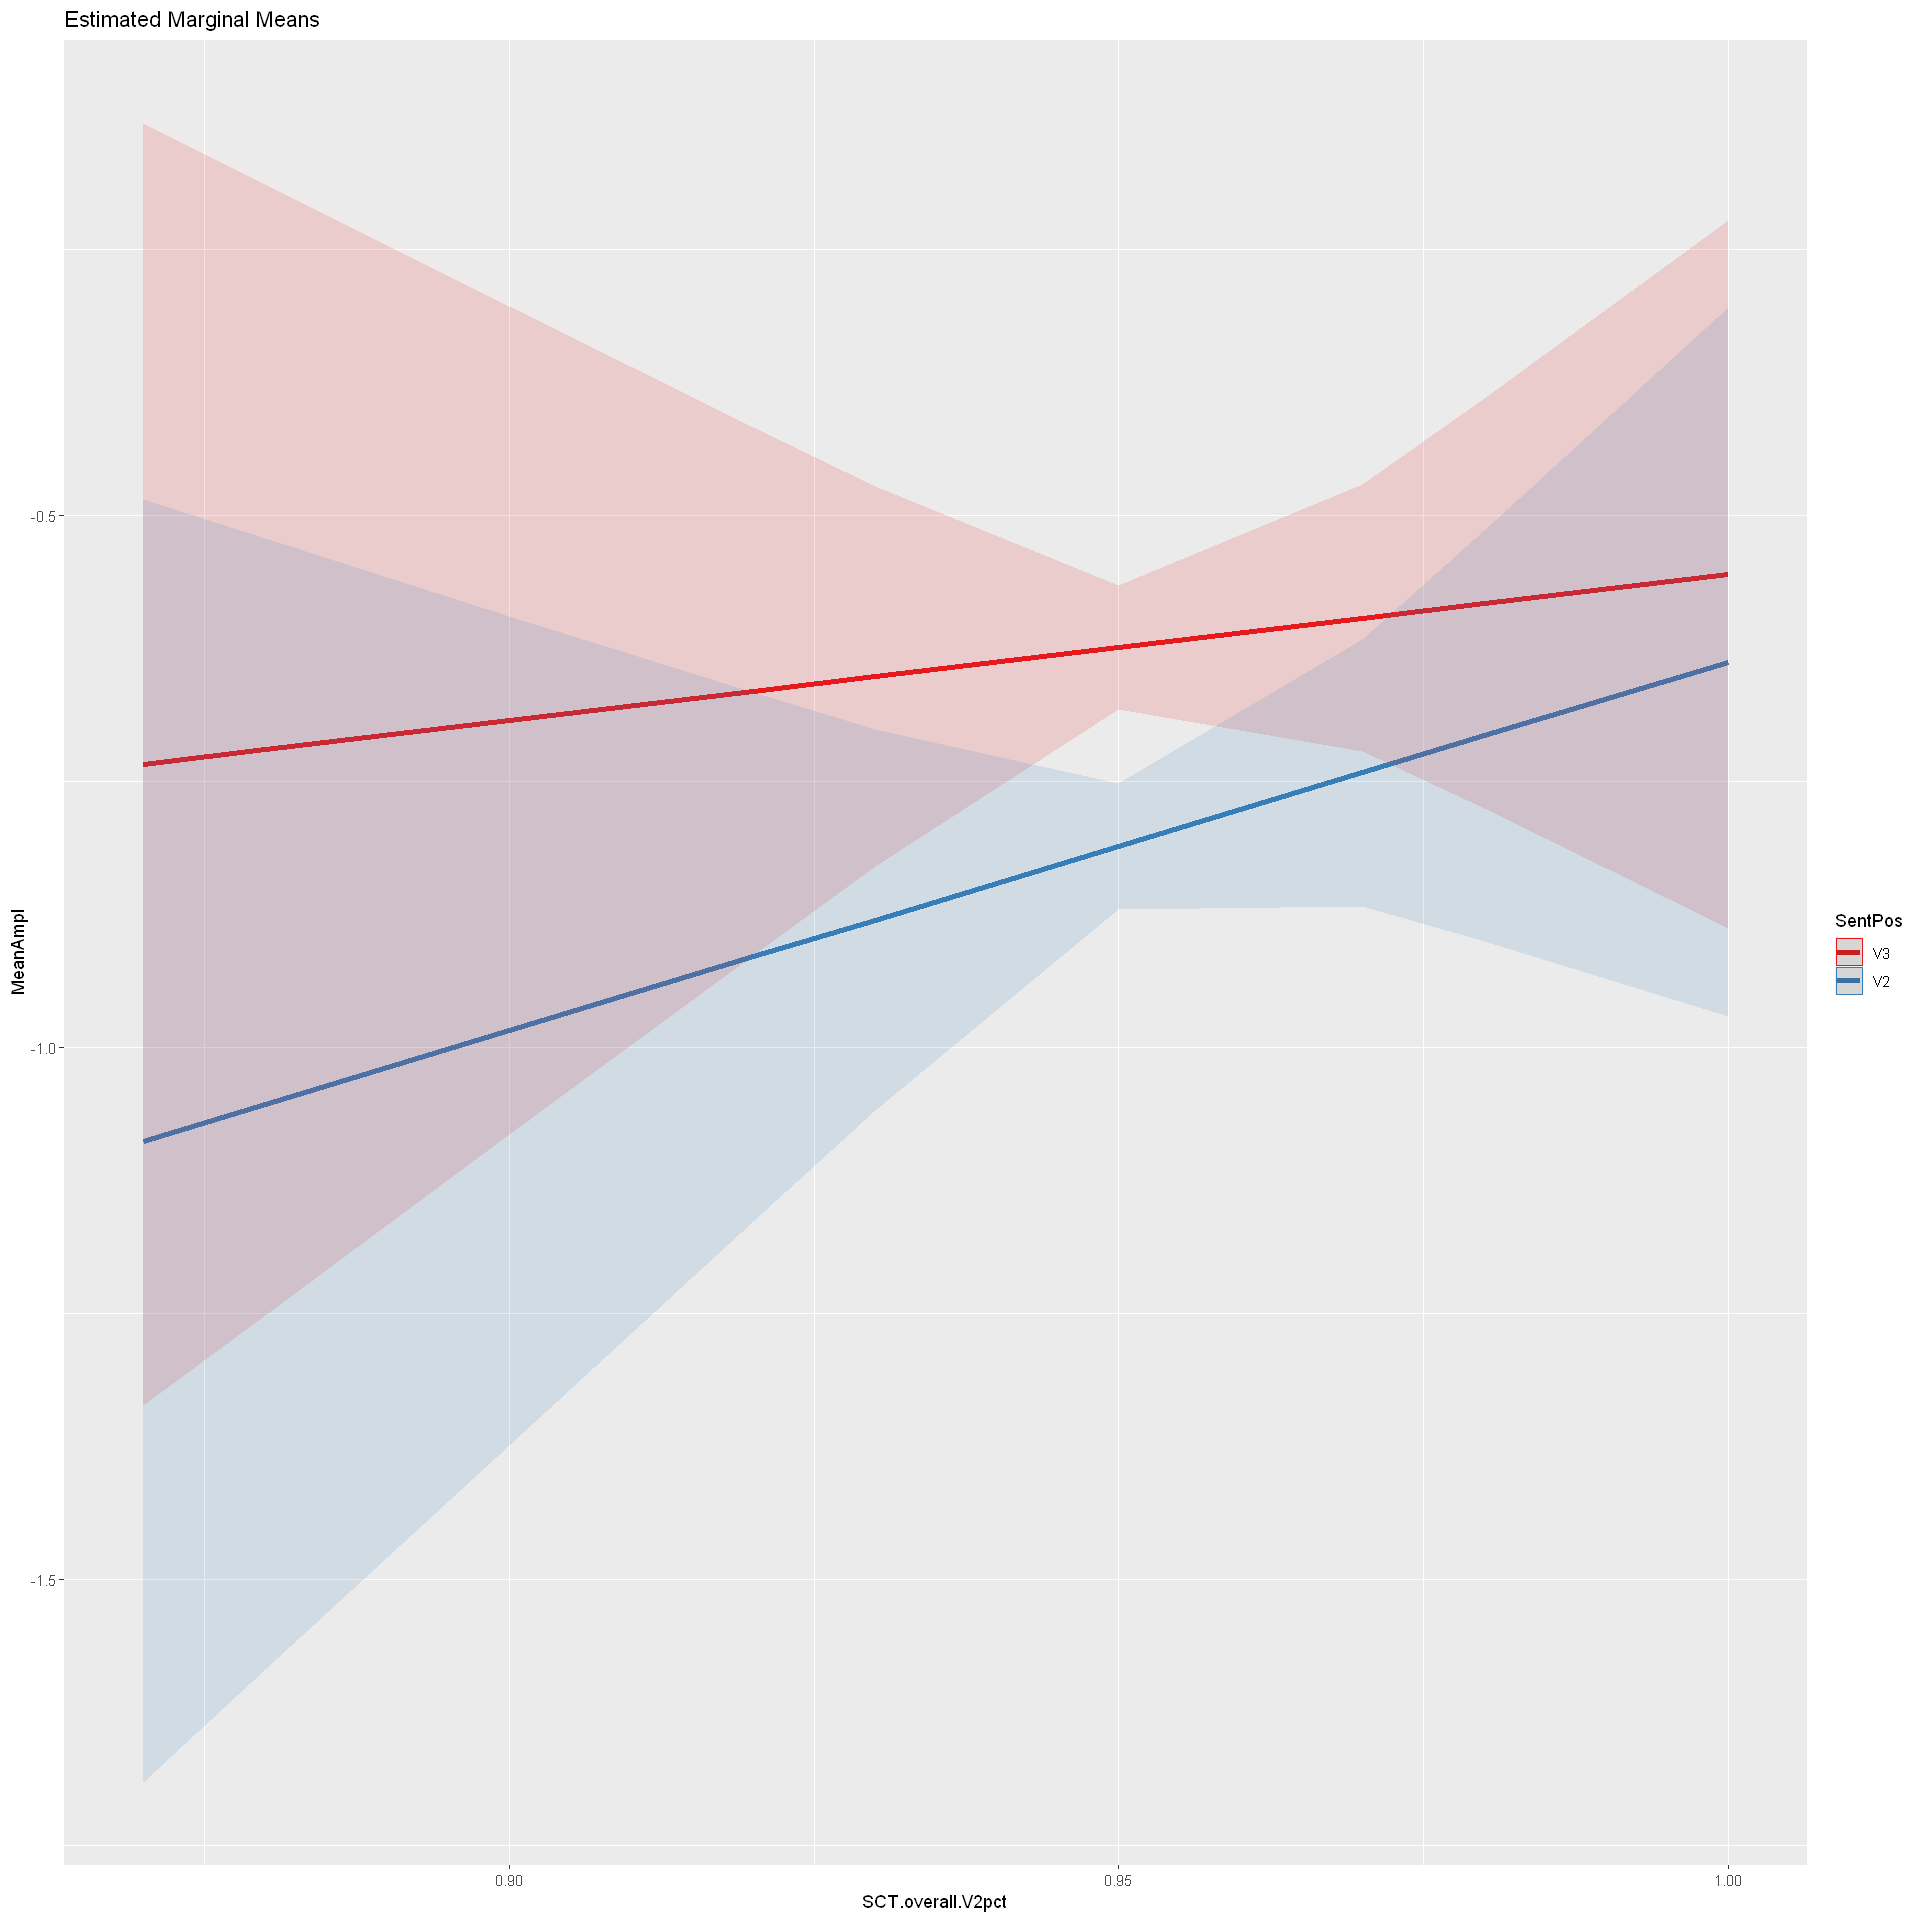

In [61]:
# save PDF
pdf(paste(out_path, 'figures/R plots/', 'lme_model_plot_', component, '_SCTxSentPos.pdf', sep="")) 
plot_model(mod, 
           type='emm',
           terms=c('SCT.overall.V2pct', 'SentPos'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )
dev.off() 

# plot in this notebook
options(repr.plot.width=16, repr.plot.height=16)
plot_model(mod, 
           type='emm',
           terms=c('SCT.overall.V2pct', 'SentPos'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



png 
  2

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



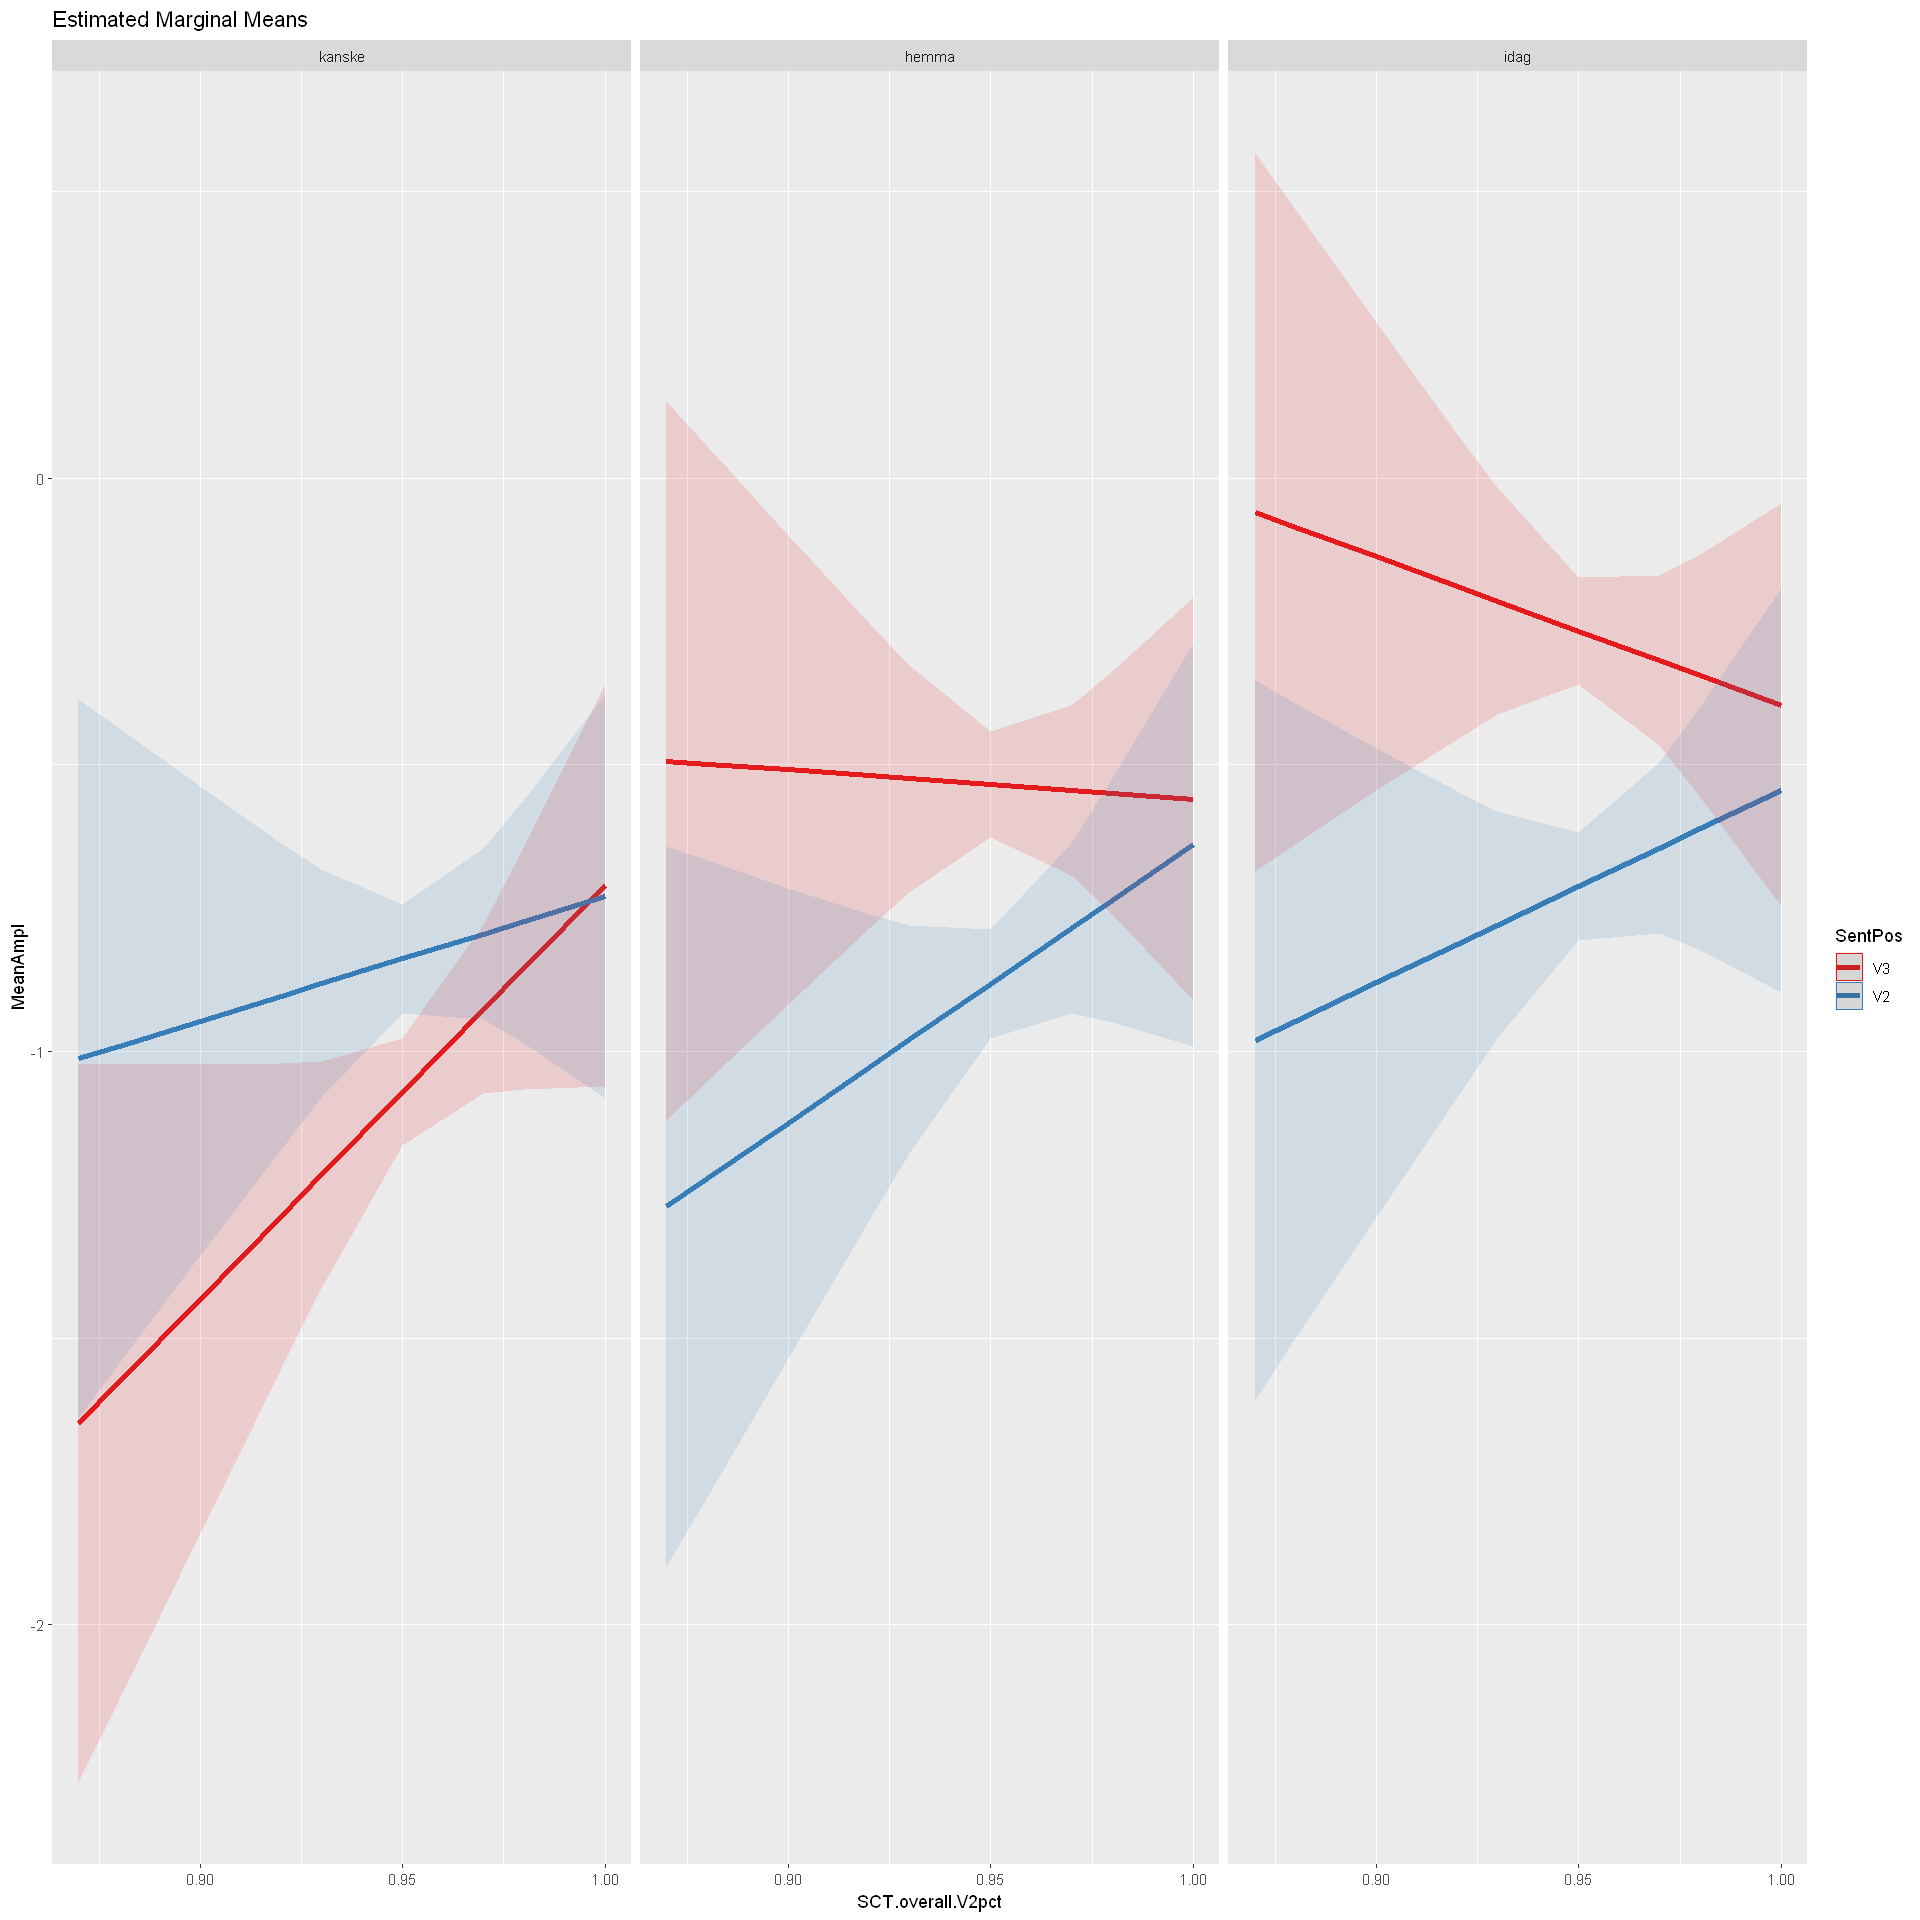

In [63]:
# save PDF
pdf(paste(out_path, 'figures/R plots/', 'lme_model_plot_', component, '_AdverbxSentPos.pdf', sep="")) 
plot_model(mod, 
           type='emm',
           terms=c('SCT.overall.V2pct', 'SentPos', 'Adverb'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )
dev.off() 

# plot in this notebook
options(repr.plot.width=16, repr.plot.height=16)
plot_model(mod, 
           type='emm',
           terms=c('SCT.overall.V2pct', 'SentPos', 'Adverb'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )

In [62]:
date()

[1] "Tue Sep 21 19:44:45 2021"